In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as api
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.initializers import Constant


#### Dataset

In [67]:
data = pd.read_csv('dataset/IMDB Dataset.csv')

In [68]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [69]:
print('Number of review :',data.shape[0])

Number of review : 50000


In [70]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

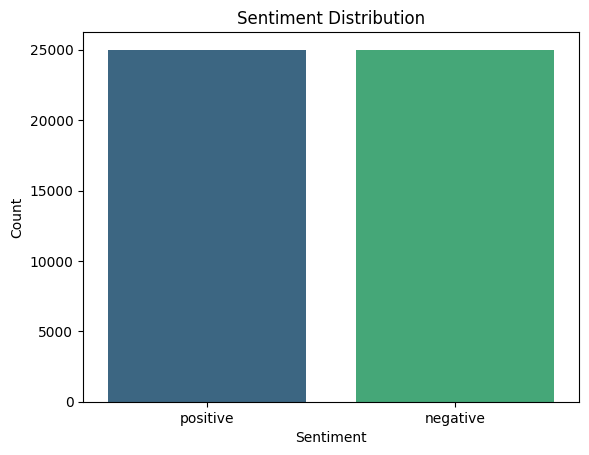

In [71]:
sns.countplot(x='sentiment', hue='sentiment', data=data, palette='viridis', legend=False)
plt.xlabel('Sentiment')  
plt.ylabel('Count')      
plt.title('Sentiment Distribution') 

plt.show()  

In [72]:
data['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

#### Preprocessing

In [73]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\badho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
def remove_html_tags(text):
    return re.compile(r'<[^>]+>').sub('', text)

In [75]:
def preprocess_review(review):
   
    
    review = review.lower()

    # Remove html tags
    review = remove_html_tags(review)

    # Remove punctuations and numbers
    review = re.sub('[^a-zA-Z]', ' ', review)

    # Single character removal
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)  

    # Remove multiple spaces
    review = re.sub(r'\s+', ' ', review)  

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

    return pattern.sub('', review)

In [76]:
data['review'] = data['review'].apply(preprocess_review)

In [77]:
data['review'][1]

'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done '

In [78]:
X = data['review']
y = data['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Embedding

In [80]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [81]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [82]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [83]:
glove = api.load("glove-wiki-gigaword-100")

In [84]:


embedding_matrix = np.zeros((vocab_length, maxlen))

for word, index in word_tokenizer.word_index.items():
    if word in glove:
        embedding_vector = glove[word]
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


In [85]:
embedding_matrix.shape

(92394, 100)

In [95]:
nn_model = Sequential()

embedding_layer = Embedding(vocab_length,
                            100,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

nn_model.add(embedding_layer)

nn_model.add(Flatten())
nn_model.add(Dense(1, activation='sigmoid'))

In [102]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.build(input_shape=(None, maxlen))


In [103]:
print(nn_model.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 100, 100)            │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          10,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,249,401 (35.28 MB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [104]:
nn_info = nn_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6576 - loss: 0.6089 - val_accuracy: 0.7531 - val_loss: 0.5115
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8020 - loss: 0.4402 - val_accuracy: 0.7679 - val_loss: 0.4952
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8258 - loss: 0.3972 - val_accuracy: 0.7661 - val_loss: 0.5001
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8352 - loss: 0.3777 - val_accuracy: 0.7490 - val_loss: 0.5342
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8437 - loss: 0.3614 - val_accuracy: 0.7569 - val_loss: 0.5197
